# **Comparing the Performance of a Simple Moving Average Strategy on Stable vs. Volatile Stocks Using Rolling Period Analysis**

### **Introduction**

This project aims to evaluate the effectiveness of a Simple Moving Average (SMA) crossover strategy in two key contexts:

- Can the SMA strategy outperform a passive buy-and-hold approach?
- Does the strategy show better **CAGR** (Compound Annual Growth Rate) results when applied to stable (low-beta) stocks compared to volatile (high-beta) ones?

In [53]:
# import libraries
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
import plotly.express as px
import matplotlib.pyplot as plt
import math as math


### **Data Selection and Stock Visualization**

- **Time Period**: January 1, 2010 – January 1, 2025
- **Visualization**: Plotted daily closing prices to understand the stock's behavior over time.

In [54]:
# define time values
START = dt.datetime(2010, 1, 1)
END = dt.datetime(2025, 1, 1)
DAYS = (END - START).days
YEARS = DAYS / 365.25

STOCK = "AAPL"

In [55]:
# import stock data
def download_stock(stock_ticker, start_time, end_time):
    data = yf.download(
            tickers=stock_ticker,
            start=start_time,
            end=end_time
    )
    data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]
    # add a column showing the stock ticker
    data["Stock"] = stock_ticker
    data_new = data.copy()
    
    # drop the columns that will not be used
    data_new.drop(columns={"High", "Low", "Volume"}, inplace=True)

    return data_new

stock_df = download_stock(STOCK, START, END)
stock_df.head(10)

C:\Users\Paulius\AppData\Local\Temp\ipykernel_22420\1352987880.py:3: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


,Close,Open,Stock
Date,,,
2010-01-04,6.431897,6.414465,AAPL
2010-01-05,6.443016,6.449628,AAPL
2010-01-06,6.340532,6.443017,AAPL
2010-01-07,6.328810,6.363974,AAPL
2010-01-08,6.370887,6.320396,AAPL
2010-01-11,6.314684,6.395530,AAPL
2010-01-12,6.242856,6.287035,AAPL
2010-01-13,6.330914,6.247364,AAPL
2010-01-14,6.294249,6.314686,AAPL


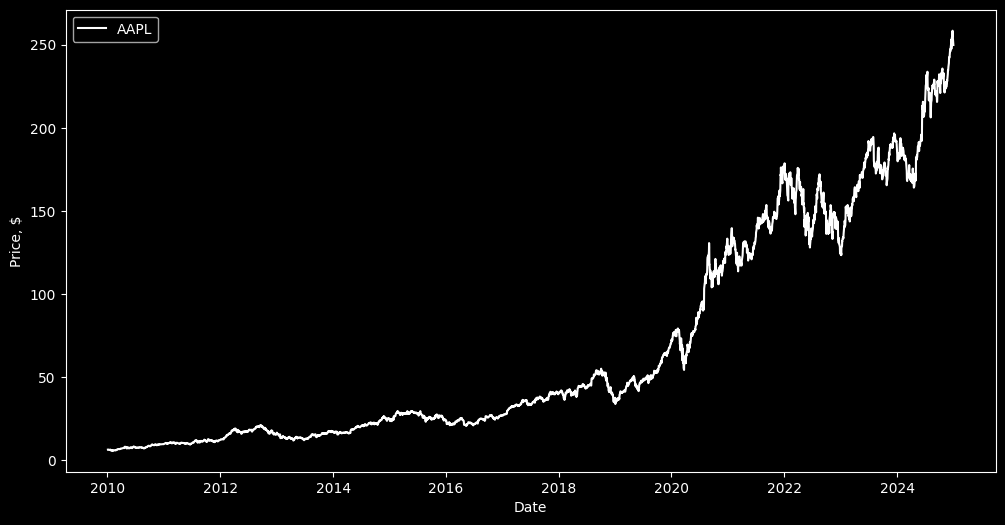

In [56]:
# plot the stock closing price graph
plt.style.use("dark_background")
plt.figure(figsize=(12, 6))
plt.plot(stock_df.index, stock_df["Close"], "w", label=STOCK)
plt.xlabel("Date")
plt.ylabel("Price, $")

plt.legend()
plt.show()

### **Moving Average Strategy Setup**

- Developed a function to calculate short- and long-term moving averages.
- Limited the maximum long MA value to ensure a balanced and comparable grid of combinations.
- Visualized the stock’s price alongside the short and long moving averages to show crossover signals.

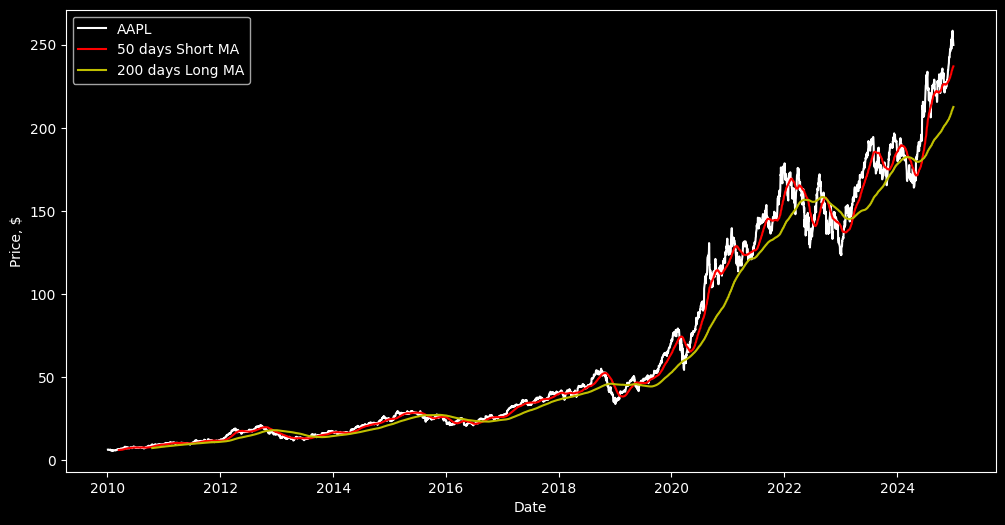

In [57]:
# function to calculate short moving average and long moving average and add it to the dataframe
def moving_average(short_ma, long_ma, df):
    df = df.copy()
    df["Short MA"] = df["Close"].rolling(window=short_ma).mean()
    df["Long MA"] = df["Close"].rolling(window=long_ma).mean()
    
    return df

SHORT_MA = 50
LONG_MA = 200

# max long moving average value allowed
MAX_LONG_MA = 300

# plot short, long moving averages, and the stock price graph
plot_ma = moving_average(SHORT_MA, LONG_MA, stock_df)
plt.figure(figsize=(12, 6))
plt.plot(plot_ma.index, plot_ma.Close, "w", label=STOCK)
plt.plot(plot_ma.index, plot_ma["Short MA"], "red", label=f"{SHORT_MA} days Short MA")
plt.plot(plot_ma.index, plot_ma["Long MA"], "y", label=f"{LONG_MA} days Long MA")

plt.xlabel("Date")
plt.ylabel("Price, $")

plt.legend()
plt.show()

### **Strategy Backtesting Framework**

- Implemented a backtest function to calculate:
  - Cumulative returns from the SMA strategy
  - Cumulative returns from simply holding the stock
- Plotted both returns on a graph for direct comparison.

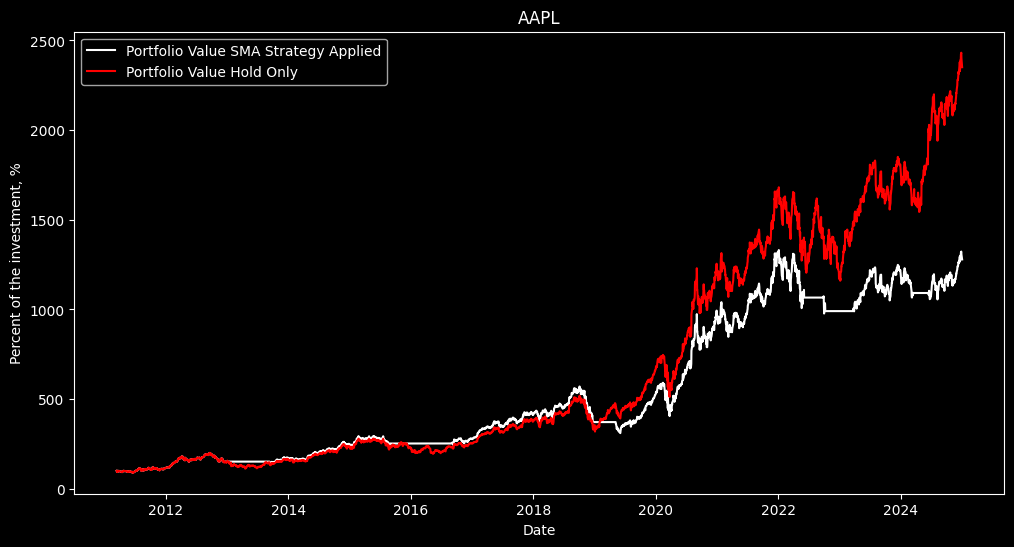

In [58]:
#backtesting the strategy on the stock
def strategy_backtest(df):
    
    df["Long"] = df["Short MA"] > df["Long MA"]
    df["Long"] = df["Long"].shift(1, fill_value=False)
    df["Daily Return"] = np.where(df["Long"], df["Close"].pct_change() + 1, 1)
    df["Strategy Cumulative Returns"] = df["Daily Return"].cumprod() * 100
    df["Holding Cumulative Returns"] = (df["Close"].pct_change() + 1).cumprod() * 100
        
    return df

ma_df = moving_average(SHORT_MA, LONG_MA, stock_df)

#remove the max value of the long moving average to give fair comparison to each Short MA and Long MA combination
fair_df = ma_df.iloc[MAX_LONG_MA:].copy()

#plot the strategy returns vs. holding returns
strategy_df = strategy_backtest(fair_df).fillna(100)
plt.figure(figsize=(12, 6))
plt.plot(strategy_df.index, strategy_df["Strategy Cumulative Returns"], "w", label="Portfolio Value SMA Strategy Applied")
plt.plot(strategy_df.index, strategy_df["Holding Cumulative Returns"], "r", label="Portfolio Value Hold Only")

plt.title(f"{STOCK}")
plt.xlabel("Date")
plt.ylabel("Percent of the investment, %")
plt.legend()

plt.show()

### **5. Performance Metrics**

For both the SMA strategy and passive holding, calculated the following:

- **CAGR** (Compound Annual Growth Rate) – measures annualized return.
- **Drawdown** – tracks the worst peak-to-trough declines.
- **Sharpe Ratio** – evaluates risk-adjusted performance.

In [59]:
# CAGR function
def cagr(df, column):
    years = round(((df.index[-1] - df.index[0]).days) / 365.25, 2)
    
    return round(((df[column].iloc[-1] / df[column].iloc[0]) ** (1/years) - 1) * 100, 2)

# drawdown function
def drawdown(df, column):
    
    return (round((df[column] - df[column].cummax()) / df[column].cummax() * 100, 2)).min()

# sharpe ratio function:
def sharpe_ratio(df, column):
    daily_return = df[column].pct_change()
    avg_return = daily_return.mean()
    std_deviation = daily_return.std()
    
    return round(avg_return / std_deviation * np.sqrt(252), 2)

# print the metrics
print("Holding the stock metrics (Benchmark)")
print(f"CAGR: {cagr(strategy_df, "Holding Cumulative Returns"):.2f}%")
print(f"Drawdown: {drawdown(strategy_df, "Holding Cumulative Returns"):.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio(strategy_df, "Holding Cumulative Returns"):.2f}")

print("\n")
print("Strategy metrics")
print(f"CAGR: {cagr(strategy_df, "Strategy Cumulative Returns"):.2f}%")
print(f"Drawdown: {drawdown(strategy_df, "Strategy Cumulative Returns"):.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio(strategy_df, "Strategy Cumulative Returns"):.2f}")


Holding the stock metrics (Benchmark)
CAGR: 25.71%
Drawdown: -43.80%
Sharpe Ratio: 0.96


Strategy metrics
CAGR: 20.28%
Drawdown: -45.61%
Sharpe Ratio: 0.88


### **Heatmap: Evaluating MA Combinations**

- Constructed a heatmap showing performance across various MA combinations.
  - **Short MAs**: 5 to 50 days (increments of 5)
  - **Long MAs**: 100 to 250 days (increments of 5)
- Focused on **CAGR** as the primary metric to assess strategy effectiveness across different parameter pairs.

In [60]:
# heatmap function 
metric = cagr

def heatmap(metric_func, df):
    short_ma_values = pd.Series(range(5, 71, 5))
    long_ma_values = pd.Series(range(120, 301, 5))

    # create a table with values for each of the short and long moving averages combinations
    metric_table = {}
    for short_value in short_ma_values:
        metric_table[short_value] = []
        for long_value in long_ma_values:
            moving_average_df = moving_average(short_value, long_value, df)
            fair_df = moving_average_df.iloc[MAX_LONG_MA:].copy() #for fair comparison
            strategy_df = strategy_backtest(fair_df).fillna(100)
            metric_value = metric_func(strategy_df, "Strategy Cumulative Returns")
            metric_table[short_value].append(metric_value)
    
    metric_table = pd.DataFrame(metric_table, index=long_ma_values)
    
    return metric_table

heatmap_table = heatmap(metric, stock_df)

# plot the heatmap
fig = px.imshow(
    heatmap_table,
    labels=dict(x="Short moving average", y="Long moving average", color="CAGR"),
    x=heatmap_table.columns,
    y=heatmap_table.index,
    color_continuous_scale="RdBu_r"

)
fig.update_traces(xgap=1, ygap=1)
fig.update_layout(title=f"{STOCK} CAGR Heatmap", xaxis_side="top", xaxis=dict(scaleanchor=None), yaxis=dict(scaleanchor=None))
fig.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'),
    xaxis=dict(showgrid=False, color='white'),
    yaxis=dict(showgrid=False, color='white')
)
fig.write_image("heatmap_stock.png")
fig.show()

![Heatmap](heatmap_stock.png)

In [61]:
# max CAGR value Short and Long moving averages combination
max_value = np.where(heatmap_table == heatmap_table.max().max())
short_ma_max_value = heatmap_table.columns[max_value[1]]
long_ma_max_value = heatmap_table.index[max_value[0]]

print("Maximum value occurs at:")
print(f"- Short MA: {short_ma_max_value[0]} days") 
print(f"- Long MA: {long_ma_max_value[0]} days")  
print(f"- Value: {heatmap_table.max().max():.2f}%")


Maximum value occurs at:
- Short MA: 10 days
- Long MA: 215 days
- Value: 24.24%


### **Rolling Period Analysis: Strategy vs Holding**

- Conducted a rolling backtest using 11 overlapping 5-year periods within the 15-year window (2010–2025).
- For each rolling window:
  - Calculated CAGR of both the SMA strategy and passive holding.
  - Measured the **Win Rate**: % of strategies that outperformed holding.
  - Calculated **Average Win**: % by which winning strategies outperformed passive holding.

**Key Outputs:**
- **Win Rate Heatmap**: shows consistency of outperformance.
- **Average Win Heatmap**: shows magnitude of outperformance when it occurs.

In [62]:
# 5-year rolling periods function
def rolling_periods_test(start_date, df_stock, years_period, heatmap_table):
    win_rate_heatmap = pd.DataFrame(0, index=heatmap_table.index, columns=heatmap_table.columns)
    avg_win_heatmap = pd.DataFrame(0, index=heatmap_table.index, columns=heatmap_table.columns)
    year = 0
    count = 1
    holding_rolling_cagr = 0
    
    while year < years_period - 5:
        
        start = (start_date + pd.DateOffset(years=year)).strftime("%Y-%m-%d")
        end = (start_date + pd.DateOffset(years=(year + 5))).strftime("%Y-%m-%d")
        rolling_stock_df = df_stock.loc[start:end].copy()
        
        # calculate holding cumulative returns for the period
        returns = rolling_stock_df["Close"].pct_change().fillna(0)
        rolling_stock_df["Holding Cumulative Returns"] = (1 + returns).cumprod() * 100
        
        # apply the strategy
        strategy_rolling_cagr = heatmap(cagr, rolling_stock_df)
        holding_rolling_cagr = pd.DataFrame(cagr(rolling_stock_df, "Holding Cumulative Returns"), index=strategy_rolling_cagr.index, columns=strategy_rolling_cagr.columns)
        
        # calculate win rate and average win percentage relative to holding
        avg_win_map = np.where((strategy_rolling_cagr - holding_rolling_cagr) > 0, (strategy_rolling_cagr - holding_rolling_cagr) / abs(holding_rolling_cagr) * 100, 0)
        performance_map = np.where((strategy_rolling_cagr - holding_rolling_cagr) < 0, 0, 1)
        win_rate_heatmap += performance_map
        avg_win_heatmap += avg_win_map
        count += 1
        year +=1 
            
    if count > 0:
            
        win_rate_heatmap = round(win_rate_heatmap / count * 100, 2)
        avg_win_heatmap = (avg_win_heatmap / win_rate_heatmap).fillna(value = 0)
        return win_rate_heatmap, avg_win_heatmap
            
    else:
            
        print("Time period selected is less than 5 years")

win_rate_heatmap, avg_win_heatmap = rolling_periods_test(START, stock_df, YEARS, heatmap_table)

# plot Win Rate % heatmap
fig = px.imshow(
    win_rate_heatmap,
    labels=dict(x="Short moving average", y="Long moving average", color="Win Rate %"),
    x=win_rate_heatmap.columns,
    y=win_rate_heatmap.index,
    color_continuous_scale="Reds"

)
fig.update_layout(title=f"{STOCK} Win Rate % Heatmap", xaxis_side="top", xaxis=dict(scaleanchor=None), yaxis=dict(scaleanchor=None))
fig.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'),
    xaxis=dict(showgrid=False, color='white'),
    yaxis=dict(showgrid=False, color='white')
)
fig.update_traces(xgap=1, ygap=1)
fig.write_image("heatmap_stock_win_rate.png")
fig.show()


# plot Average Win Rate heatmap
fig = px.imshow(
    avg_win_heatmap,
    labels=dict(x="Short moving average", y="Long moving average", color="CAGR"),
    x=avg_win_heatmap.columns,
    y=avg_win_heatmap.index,
    color_continuous_scale="Reds"

)
fig.update_layout(title=f"{STOCK} Average Win %", xaxis_side="top", xaxis=dict(scaleanchor=None), yaxis=dict(scaleanchor=None), plot_bgcolor='black')
fig.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'),
    xaxis=dict(showgrid=False, color='white'),
    yaxis=dict(showgrid=False, color='white')
)
fig.update_traces(xgap=1, ygap=1)
fig.write_image("heatmap_stock_avg_win.png")
fig.show()



![Heatmap](heatmap_stock_win_rate.png)

![Heatmap](heatmap_stock_avg_win.png)

### **Visualizing Rolling Period Results**

- Plotted **Win Rate (%)** on the y-axis and **Average Win (%)** on the x-axis in a scatterplot.
- Each point represents a unique short–long MA pair.
- Helps visualize the balance between consistency and potential upside.

In [63]:
# create dataframe with values from both win rate and average win rate heatmaps
combination_map = {
    (row, column): {
        'win_rate': win_rate_heatmap.loc[row, column],
        'avg_win': avg_win_heatmap.loc[row, column]
    }
    for row in win_rate_heatmap.index
    for column in win_rate_heatmap.columns
}

values = []
for (row, column), metrics in combination_map.items():
    values.append({
        "combination" : [int(column), int(row)],
        "avg_win" : metrics["avg_win"],
        "win_rate" : metrics["win_rate"],
        "short MA" : column,
        "long MA" : row
    })
values = []
for (row, column), metrics in combination_map.items():
    values.append({
        "combination" : [int(column), int(row)],
        "avg_win" : metrics["avg_win"],
        "win_rate" : metrics["win_rate"],
        "short MA" : column,
        "long MA" : row
    })
values = pd.DataFrame(values) 

# divide the moving average combinations into four groups according to their length
def assign_type(df):
    if df["short MA"] <= 35 and df["long MA"] <= 210:
        return "Small-Small"
    elif df["short MA"] <= 35 and df["long MA"] > 210:
        return "Small-Big"
    elif df["short MA"] > 35 and df["long MA"] > 210:
        return "Big-Big"
    else:
        return "Big-small"
    
values["MA pairs"] = values.apply(assign_type, axis=1)     

# plot the scatterplot
fig = px.scatter(
    values,
    x="avg_win",
    y="win_rate",
    color="MA pairs",
    labels={'avg_win': 'Average Win %', 'win_rate': 'Win Rate %'},
    title=f"{STOCK} Avg Win vs Win Rate (Bubbles are Short MA & Long MA pairs)",
    hover_data={
        "short MA": True,
        "long MA": True,
        "MA pairs": True,
        "avg_win": ':.2f',
        "win_rate": ':.2f'
    }
    
)


fig.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'),
    xaxis=dict(showgrid=False, color='white'),
    yaxis=dict(showgrid=False, color='white')

)
fig.write_image("scatterplot_stock.png")
fig.show()

![Heatmap](scatterplot_stock.png)

### **Applying the Strategy to Stable vs. Volatile Stocks**

- Selected 30 stocks based on **5-year Beta values** (measure of volatility relative to the market):
  - **Stable Stocks**: Beta between 0.5 and 1.0
  - **Volatile Stocks**: Beta > 2.0
  - All stocks had at least 15 years of historical data.

- Ran the rolling 5-year backtest for each stock.
- Plotted the final metrics (Win Rate & Average Win) for all stocks, getting two scatterplots for stable stocks and volatile stocks

In [64]:
# stable and volatile stocks dataframe
multiple_stocks_test = pd.DataFrame(
    {"Stable Stocks": ["WMT", "V", "XOM", "HD", "BAC", "CVX", "TMUS", "PM", "IBM", "BSX", "CMCSA", "WMB", "AMT", "EOG", "CVS"], 
    "Volatile Stocks": ["RCL", "CCL", "XPO", "GTLS", "AA", "GAP", "MOD", "CAR", "SM", "DAN", "CENX", "TWI", "MTW", "MDRX", "BYON"]}, 
    index=list(range(1, 16))
)

print(multiple_stocks_test)


   Stable Stocks Volatile Stocks
1            WMT             RCL
2              V             CCL
3            XOM             XPO
4             HD            GTLS
5            BAC              AA
6            CVX             GAP
7           TMUS             MOD
8             PM             CAR
9            IBM              SM
10           BSX             DAN
11         CMCSA            CENX
12           WMB             TWI
13           AMT             MTW
14           EOG            MDRX
15           CVS            BYON


In [ ]:
# download stocks data
stock_data_stable = pd.DataFrame()
for stock in multiple_stocks_test["Stable Stocks"]:
    stock_download = download_stock(stock, START, END)
    stock_data_stable = pd.concat([stock_data_stable, stock_download])
    
stock_data_volatile = pd.DataFrame()
for stock in multiple_stocks_test["Volatile Stocks"]:
    stock_download = download_stock(stock, START, END)
    stock_data_volatile = pd.concat([stock_data_volatile, stock_download])

In [66]:
# create the scatterplot with win rate and average win % by averaging out the results of the stable stocks
win_rate_heatmap_multiple = pd.DataFrame(0, index=heatmap_table.index, columns=heatmap_table.columns)
avg_win_heatmap_multiple = pd.DataFrame(0, index=heatmap_table.index, columns=heatmap_table.columns)

for stock in multiple_stocks_test["Stable Stocks"]:
    
    stock_info = stock_data_stable.loc[stock_data_stable["Stock"] == stock]
    win_rate_heatmap, avg_win_heatmap = rolling_periods_test(START, stock_info, YEARS, heatmap_table)
    win_rate_heatmap_multiple += win_rate_heatmap
    avg_win_heatmap_multiple += avg_win_heatmap

win_rate_heatmap_multiple = win_rate_heatmap_multiple / len(multiple_stocks_test["Stable Stocks"])
avg_win_heatmap_multiple = avg_win_heatmap_multiple / len(multiple_stocks_test["Stable Stocks"])

combination_map = {
    (row, column): {
        'win_rate': win_rate_heatmap_multiple.loc[row, column],
        'avg_win': avg_win_heatmap_multiple.loc[row, column]
    }
    for row in win_rate_heatmap_multiple.index
    for column in win_rate_heatmap_multiple.columns
}

values = []
for (row, column), metrics in combination_map.items():
    values.append({
        "combination" : [int(column), int(row)],
        "avg_win" : metrics["avg_win"],
        "win_rate" : metrics["win_rate"],
        "short MA" : column,
        "long MA" : row
    })
values = pd.DataFrame(values) 

# divide the moving average combinations into four groups according to their length
values["MA pairs"] = values.apply(assign_type, axis=1)     


# plot the scatterplot
fig = px.scatter(
    values,
    x="avg_win",
    y="win_rate",
    color="MA pairs",
    labels={'avg_win': 'Average Win %', 'win_rate': 'Win Rate %'},
    title="Stable Stocks Avg Win vs Win Rate (Bubbles are Short MA & Long MA pairs)",
    hover_data={
        "short MA": True,
        "long MA": True,
        "MA pairs": True,
        "avg_win": ':.2f',
        "win_rate": ':.2f'
    }
    
)

fig.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'),
    xaxis=dict(showgrid=False, color='white'),
    yaxis=dict(showgrid=False, color='white')

)

fig.write_image("scatterplot_stable.png")
fig.show()





![Scatterplot](scatterplot_stable.png)

In [67]:

# create the scatterplot with win rate and average win % by averaging out the results of the stable stocks
win_rate_heatmap_multiple = pd.DataFrame(0, index=heatmap_table.index, columns=heatmap_table.columns)
avg_win_heatmap_multiple = pd.DataFrame(0, index=heatmap_table.index, columns=heatmap_table.columns)

for stock in multiple_stocks_test["Volatile Stocks"]:
    
    stock_info = stock_data_volatile.loc[stock_data_volatile["Stock"] == stock]
    win_rate_heatmap, avg_win_heatmap = rolling_periods_test(START, stock_info, YEARS, heatmap_table)
    win_rate_heatmap_multiple += win_rate_heatmap
    avg_win_heatmap_multiple += avg_win_heatmap

# find the average win rate for each of the stocks as well as average average relative win rate
win_rate_heatmap_multiple = win_rate_heatmap_multiple / len(multiple_stocks_test["Stable Stocks"])
avg_win_heatmap_multiple = avg_win_heatmap_multiple / len(multiple_stocks_test["Volatile Stocks"])

combination_map = {
    (row, column): {
        "win_rate": win_rate_heatmap_multiple.loc[row, column],
        "avg_win": avg_win_heatmap_multiple.loc[row, column]
    }
    for row in win_rate_heatmap_multiple.index
    for column in win_rate_heatmap_multiple.columns
}

values = []
for (row, column), metrics in combination_map.items():
    values.append({
        "combination" : [int(column), int(row)],
        "avg_win" : metrics["avg_win"],
        "win_rate" : metrics["win_rate"],
        "short MA" : column,
        "long MA" : row
    })
values = pd.DataFrame(values) 

# divide the moving average combinations into four groups according to their length
values["MA pairs"] = values.apply(assign_type, axis=1)

# plot the scatterplot     
fig = px.scatter(
    values,
    x="avg_win",
    y="win_rate",
    color="MA pairs",
    labels={'avg_win': 'Average Win %', 'win_rate': 'Win Rate %'},
    title="Volatile Stocks Avg Win vs Win Rate (Bubbles are Short MA & Long MA pairs)",
    hover_data={
        "short MA": True,
        "long MA": True,
        "MA pairs": True,
        "avg_win": ':.2f',
        "win_rate": ':.2f'
    }
    
)

fig.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'),
    xaxis=dict(showgrid=False, color='white'),
    yaxis=dict(showgrid=False, color='white')

)

fig.write_image("scatterplot_volatile.png")
fig.show()

![Scatterplot](scatterplot_volatile.png)

### **Results**

- A rolling 5-year strategy test was conducted on two sets of stocks: **15 stable** and **15 volatile** tickers.

#### Stable Stocks
- The strategy **performed poorly** on stable stocks, winning against a buy-and-hold approach only about **15% to 25%** of the time.
- When the strategy did outperform, the **average improvement in CAGR** was modest, around **10% to 18%** over the buy-and-hold method.
- These results indicate that the moving average crossover strategy is **largely ineffective** for stable stocks over rolling 5-year periods.

#### Volatile Stocks
- For volatile stocks, the strategy delivered **better results**, winning approximately **50%** of the time across the 11 overlapping 5-year periods.
- When successful, the strategy achieved **CAGR improvements** ranging from **100% to 300%**, and in rare cases, even up to **350%** compared to holding.
- This suggests that the strategy is **much more effective** in high-volatility environments.

#### Moving Average Groupings
To better analyze the performance, moving average (MA) combinations were grouped into four categories:

- **Small-Small**: short MA (5–35), long MA (120–210)  
- **Small-Big**: short MA (5–35), long MA (210–300)  
- **Big-Small**: short MA (35–70), long MA (120–210)  
- **Big-Big**: short MA (35–70), long MA (210–300)

#### Observations by Group

- For **stable stocks**:
  - The **"Big-Big"** group performed best, with **"Small-Big"** following closely.
  - However, overall performance was still weak.

- For **volatile stocks**:
  - The **"Small-Big"** group had the **highest win rate** with **"Big-Big"** and **"Small-Big"** coming very close.
  - The **"Small-Small"** group had a **slightly lower win rate** than **"Small-Big"** but **much higher average win %** (CAGR) when the strategy outperformed holding.
  - The **"Big-Small"** group was consistently the **worst-performing** across both stable and volatile categories.

#### Notable Moving Average Combinations (Volatile Stocks Only)
The following combinations stood out for their strong performance in volatile stocks:

- **(5, 185)**, **(10, 135)**, **(15, 120)**, **(15, 125)**, **(15, 130)**, **(10, 130)**, **(20, 120)**

These results suggest that the most effective configurations for volatile stocks are:

- **Short MA**: between **10 and 20**
- **Long MA**: between **120 and 135**

#### Final Notes
- Given the strategy's poor performance on stable stocks, it is **not meaningful** to highlight specific MA combinations for them.
- Overall, this analysis reinforces the idea that **strategy effectiveness depends heavily on stock volatility**, and that **customizing MA settings by stock type** may be essential for optimal performance.


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


### **Limitations**

#### Small sample size
- Each of the groups only included 15 stocks. This does provide insight, however, a much larger sample size is needed for generalization.

#### Historical bias
- This strategy was tested on historical data, which may not reflect future market conditions.

#### Transaction costs and slippage
- The strategy didn't take into account trading fees, slippage, or tax implications, which could potentially reduce strategy's profitability.

#### Overfitting
- Highlighting the best-performing moving average combinations may lead to overfitting. These combinations might not perform similarly out-of-sample.

#### Rolling window design
- Different rolling periods (i.e. 3 or 10 years) could provide different results.

----------

### **Next Steps**

#### Larger and more diverse dataset
- Include more stocks across sectors and market conditions to improve statistical significance.

#### Try adaptive strategies
- Incorporate machine learning to adapt moving averages based on volatility.

#### Walk-forward testing
- Instead of analyzing historical performance alone, simulate real-time strategy deployment with walk-forward testing to avoid look-ahead bias.